Locating CAR files

In [22]:
from pathlib import Path
import glob
from collections import Counter

DATA_DIR = Path("OneDrive_3_10-3-2025").expanduser()

#Grabing all CSVs that start with “CAR”
files = []
for pattern in ("**/*.csv", "**/*.CSV", "**/*.xlsx", "**/*.XLSX"):
    files.extend(DATA_DIR.glob(pattern))

#De-duplicate and sort
files = sorted(set(p.resolve() for p in files))

Aggregating all dataframes

In [20]:
#Aggregating all dataframes

import warnings
warnings.filterwarnings("ignore", message="Workbook contains no default style")
import pandas as pd

def load_car_file(path): #Loading the files here first to get header from row 3 or scan first 10 rows for the header by searching for Contact Session ID
    ext = path.suffix.lower()
    name = path.name

    #Reading with no header so we can detect the header row reliably
    if ext == ".csv":
        raw = pd.read_csv(path, header=None, dtype=str, keep_default_na=False, on_bad_lines="skip")
    elif ext == ".xlsx":
        raw = pd.read_excel(path, header=None, dtype=str, engine="openpyxl")
    else:
        return None

    #Finding the header row (looking for 'Contact Session ID' in first 10 rows)
    header_row = None
    for r in range(min(10, len(raw))):
        row_vals = [str(v).strip() for v in raw.iloc[r].tolist()]
        if any(v == "Contact Session ID" for v in row_vals):
            header_row = r
            break

    #Some files have header at row index 1 so this would capture that
    if header_row is None:
        header_row = 1

    #Reading again with proper header and skipping pre-header lines
    if ext == ".csv":
        df = pd.read_csv(path, header=header_row, dtype=str, keep_default_na=False, on_bad_lines="skip")
    else:
        df = pd.read_excel(path, header=header_row, dtype=str, engine="openpyxl")

    #Dropping any fully empty columns and adding source tag
    df = df.loc[:, ~df.columns.astype(str).str.startswith("Unnamed")]
    df["SourceFile"] = name
    return df

#Running function on CAR files
frames = []
bad = []

for p in files:
    df = load_car_file(p)
    frames.append(df)

all_calls = pd.concat(frames, ignore_index=True)

Normalizing Columns and Parsing the Timestamp

In [28]:
#Standardizing Column Names
all_calls.columns = (all_calls.columns.astype(str).str.strip().str.replace(r"\s+", " ", regex=True))

#Parsing timestamp column
all_calls["Activity Start Timestamp"] = pd.to_datetime(
    all_calls["Activity Start Timestamp"], errors="coerce", infer_datetime_format=True
)
all_calls["Date"] = all_calls["Activity Start Timestamp"].dt.date

/var/folders/7t/nv16yg3d7bz1xdvjj3kht86w0000gn/T/ipykernel_58969/2216778028.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  all_calls["Activity Start Timestamp"] = pd.to_datetime(


Filtering Data for Family Menu + Flagging Chatbot

In [31]:
#Filtering to Family Menu EP only
family = all_calls[all_calls["EP Name"] == "Legal Family Menu Telephony EP"].copy()

#Adding Chatbot Time Period Flag
chatbot_start = pd.to_datetime("2025-08-11").date()
chatbot_end   = pd.to_datetime("2025-08-29").date()
family["ChatbotPeriod"] = family["Date"].between(chatbot_start, chatbot_end)

#Adding chatbot transfer flag
family["ChatbotTransfer"] = family["Activity Name"].eq("TransferToSafeHaven")

Analysis 1: Termination Reason during Chatbot vs Not

In [43]:
# derive call-level flags
call_flags = (
    family.groupby("Contact Session ID")
    .agg({
        "Date": "first",
        "ChatbotPeriod": "max",         # within chatbot window
        "ChatbotTransfer": "max",       # ever transferred to SafeHaven
        "Termination Reason": "last"    # last termination reason in the call
    })
    .reset_index()
    .rename(columns={"ChatbotTransfer": "ChatbotUsed"})
)

# restrict to period where termination reason exists (after March)
march_cut = pd.to_datetime("2025-03-01").date()
call_flags = call_flags[call_flags["Date"] >= march_cut]

termination_counts = (
    call_flags.groupby(["ChatbotUsed", "Termination Reason"])
    .size()
    .reset_index(name="Count")
)

termination_percent = (
    termination_counts.groupby("ChatbotUsed")
    .apply(lambda g: g.assign(Percent = 100 * g["Count"] / g["Count"].sum()))
    .reset_index(drop=True)
)

termination_percent

,ChatbotUsed,Termination Reason,Count,Percent
0,False,Agent Left,18,0.213980
1,False,Customer Left,1095,13.017118
2,False,N/A,7299,86.768902
3,True,Agent Left,83,20.145631
4,True,Customer Left,328,79.611650
5,True,Participant Invite timer expired,1,0.242718


Analysis 2: Duration of calls (with vs without chatbot)

In [47]:
#Computing duration of each call
call_durations = (
    family.groupby("Contact Session ID")["Activity Start Timestamp"]
    .agg(["min", "max"])
    .reset_index()
)
call_durations["CallDurationSec"] = (call_durations["max"] - call_durations["min"]).dt.total_seconds()

#Adding important info for each call
call_flags = (
    family.groupby("Contact Session ID")
    .agg({
        "Date": "first",              
        "ChatbotPeriod": "max",
        "ChatbotTransfer": "max"
    })
    .reset_index()
)

#Merging with durations df
call_summary = pd.merge(call_durations, call_flags, on="Contact Session ID")
call_summary.head()

import numpy as np

#Marking each period explicitly
def label_period(date):
    if date < chatbot_start:
        return "Before"
    elif chatbot_start <= date <= chatbot_end:
        return "During"
    else:
        return "After"

call_summary["Period"] = call_summary["Date"].apply(label_period)

#Getting average duration
duration_by_period = (
    call_summary.groupby("Period")["CallDurationSec"]
    .mean()
    .round(2)
)
print(duration_by_period, "In Seconds")

Period
After     33.01
Before    32.13
During    97.95
Name: CallDurationSec, dtype: float64 In Seconds


Visualizing Analysis Data

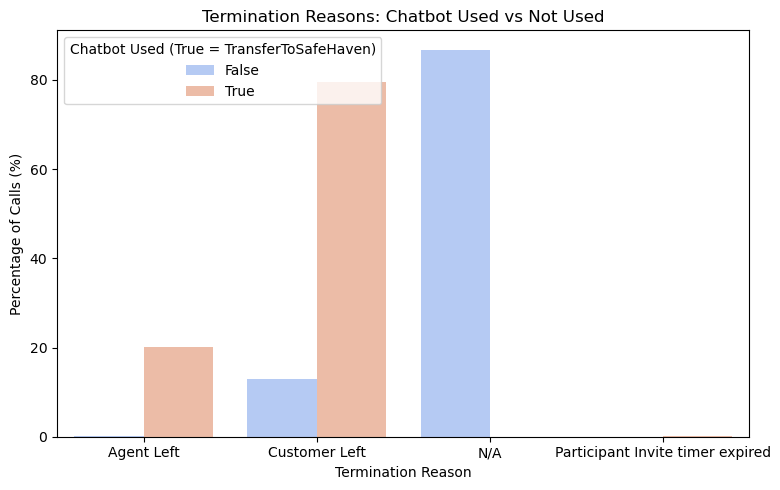

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

termination_percent["ChatbotUsed"] = termination_percent["ChatbotUsed"].astype(str)
termination_percent["Termination Reason"] = termination_percent["Termination Reason"].astype(str)

plt.figure(figsize=(8,5))
sns.barplot(
    data=termination_percent,
    x="Termination Reason", y="Percent", hue="ChatbotUsed", palette="coolwarm"
)
plt.title("Termination Reasons: Chatbot Used vs Not Used")
plt.ylabel("Percentage of Calls (%)")
plt.xlabel("Termination Reason")
plt.legend(title="Chatbot Used (True = TransferToSafeHaven)")
plt.tight_layout()
plt.show()


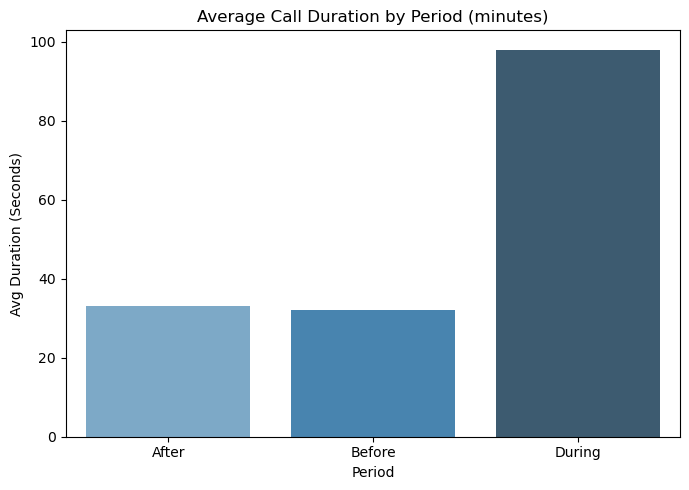

In [52]:
plt.figure(figsize=(7,5))
sns.barplot(
    x=duration_by_period.index,
    y=duration_by_period.values,
    palette="Blues_d"
)
plt.title("Average Call Duration by Period (minutes)")
plt.ylabel("Avg Duration (Seconds)")
plt.xlabel("Period")
plt.tight_layout()
plt.show()